### Initialization

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Downloading all Dependencies

In [3]:
# from fastai.imports import *
# from fastai.structured import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import graphviz

# from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.tree import export_graphviz
# from sklearn.ensemble import forest

from sklearn import metrics

In [3]:
# ??display # Uncomment for Documentation 

### Python 3 Note:01

In [4]:
name = "Thinam";age = 19
f"Hello {name.upper()}, You are {age}"

'Hello THINAM, You are 19'

### Writing Functions

In [4]:
def add_datepart(df, fldname, drop = True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format = True)
    targ_pre = re.sub("[Dd]ate$", '', fldname)
    for n in ('Year', 'Month', 'Week', 'DayofWeek', 'DayofYear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elasped'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis = 1, inplace = True)

In [5]:
def apply_cats(df, trn):
    for n, c in df.items():
        if trn[n].dtype.name == "category":
            df[n] = pd.Categorical(c, categories = trn[n].cat.categories, ordered = True )

In [6]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [7]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [8]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum(): 
            df[name + '_na'] = pd.isnull(col)
        df[name] = col.fillna(col.median())

In [9]:
def proc_df(df, y_fld, skip_flds = None, do_scale = False, prepoc_fn = None, max_n_cat = None, subset = None):
    if not skip_flds:
        skip_flds = []
    if subset: df = get_sample(df, subset)
    df = df.copy()
    if prepoc_fn: prepoc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)
    
    for n, c in df.items(): fix_missing(df, c, n)
    if do_scale: mapper = scale_vars(df)
    for n, c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na = True), y]
    if not do_scale: return res
    return res + [mapper]

In [10]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [11]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [12]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [13]:
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n))

In [14]:
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n_samples))

### Reading and Pre-processing

In [15]:
PATH = "C:\\Users\\DELL\\Blue Book for Bulldozers\\Train.csv"

In [16]:
df_raw = pd.read_csv(PATH, low_memory = False, parse_dates = ["saledate"])

In [17]:
df_raw.SalePrice

0         66000
1         57000
2         10000
3         38500
4         11000
          ...  
401120    10500
401121    11000
401122    11500
401123     9000
401124     7750
Name: SalePrice, Length: 401125, dtype: int64

In [18]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [19]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [20]:
df_raw.SalePrice

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
401120     9.259131
401121     9.305651
401122     9.350102
401123     9.104980
401124     8.955448
Name: SalePrice, Length: 401125, dtype: float64

### Initial Processing

In [21]:
RandomForestRegressor

sklearn.ensemble._forest.RandomForestRegressor

In [22]:
df_raw.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
401120   2011-11-02
401121   2011-11-02
401122   2011-11-02
401123   2011-10-25
401124   2011-10-25
Name: saledate, Length: 401125, dtype: datetime64[ns]

In [23]:
fld = df_raw.saledate
fld.dt.year

0         2006
1         2004
2         2004
3         2011
4         2009
          ... 
401120    2011
401121    2011
401122    2011
401123    2011
401124    2011
Name: saledate, Length: 401125, dtype: int64

In [24]:
add_datepart(df_raw, "saledate")
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [25]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDayofWeek', 'saleDayofYear', 'saleIs_mon

In [26]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleWeek,saleDayofWeek,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElasped
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,46,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,13,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,9,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,20,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,30,3,204,False,False,False,False,False,False,1248307200


In [27]:
train_cats(df_raw)

In [28]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [29]:
df_raw.UsageBand.cat.set_categories(["High", "Medium", "Low"], ordered = True, inplace = True)

In [30]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

### Saving 

In [31]:
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('tmp/raw')

C:\Users\DELL\Anaconda3\envs\THINAM\lib\site-packages\pyarrow\feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


### Preprocessing

In [32]:
df_raw = pd.read_feather('tmp/raw')

In [32]:
df, y = proc_df(df_raw, "SalePrice")

In [33]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDayofWeek', 'saleDayofYear', 'saleIs_month_end',
    

In [34]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElasped,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


In [35]:
m = RandomForestRegressor(n_jobs = -1)
m.fit(df, y)
m.score(df, y)

0.9881354757581724

In [37]:
n_valid = 12000
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 65), (389125,), (12000, 65))

In [38]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
          rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train),
          m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [39]:
m = RandomForestRegressor(n_jobs = -1)
m.fit(X_train, y_train)
print_score(m)

[0.07570802226828136, 0.23555278122493672, 0.9880210534120006, 0.9009112278725988]


### Increasing Execution Speed

In [58]:
df_trn, y_trn = proc_df(df_raw, "SalePrice", subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [41]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 11.2 s
[0.09274778438770677, 0.3476970282158882, 0.9815220692590353, 0.7841013476218991]


### Building Single Tree

In [42]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5281699476216257, 0.5803526705251617, 0.4007698994646479, 0.3985051013184835]


In [57]:
# Building much deeper Decision Tree
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.7682219008410604e-17, 0.4786821184651023, 1.0, 0.5907936327107353]


### Bagging 

In [59]:
m = RandomForestRegressor(n_estimators = 10, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11212176839021047, 0.35226888838910597, 0.9727931625545948, 0.7783863269344307]


In [61]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([8.9226583 , 9.01796848, 9.15904708, 9.82552601, 9.21034037,
        9.30565055, 9.82552601, 9.15904708, 9.39266193, 9.82552601]),
 9.364395181975647,
 9.104979856318357)

In [62]:
preds.shape

(10, 12000)

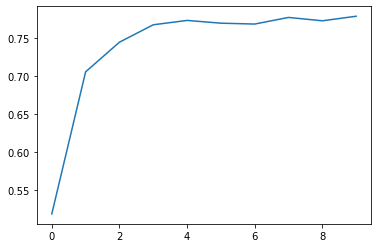

In [63]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [64]:
m = RandomForestRegressor(n_estimators = 20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10177319362960441, 0.3354572242777067, 0.9775836453093569, 0.7990341463410017]


In [65]:
m = RandomForestRegressor(n_estimators = 40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09660755019948872, 0.3364232135811778, 0.9798014440021593, 0.7978750693411334]


In [66]:
m = RandomForestRegressor(n_estimators = 80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09435943138402425, 0.33311906997131135, 0.980730572387596, 0.8018258680049293]


### Out-Of-Bag (OOB) score

In [70]:
m = RandomForestRegressor(n_estimators = 80, n_jobs=-1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.09409400972083899, 0.3336430189711882, 0.9808388250589545, 0.8012019782008348, 0.8613489241168734]


### Reducing Over-fitting

In [71]:
df_trn, y_trn = proc_df(df_raw, "SalePrice")
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [72]:
len(df_raw), len(X_train)

(401125, 389125)

In [79]:
set_rf_samples(20000)

In [80]:
m = RandomForestRegressor(n_jobs=-1, n_estimators = 80, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3min 53s
[0.07607506947741367, 0.23671185772518702, 0.9879046193236094, 0.8999336631887714, 0.912362155920057]


### Building Tree

In [82]:
reset_rf_samples()

In [83]:
m = RandomForestRegressor(n_jobs=-1, n_estimators = 80, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3min 50s
[0.07607680442814876, 0.23527922536704607, 0.9879040676283161, 0.901141244891803, 0.9122755036117928]


In [84]:
m = RandomForestRegressor(n_estimators = 80, n_jobs=-1, min_samples_leaf=3, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11501793368399757, 0.2326517273356036, 0.9723518581858436, 0.9033369405705756, 0.9113506369399544]


In [85]:
m = RandomForestRegressor(n_estimators = 80, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11943566107759666, 0.22661457033082186, 0.9701871934847331, 0.9082885344927102, 0.9147047141702004]
